In [1]:
import os
import torch
import clip
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR100
device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.

In [2]:
img_id = 3
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
img = cifar100[img_id][0].resize((100,100))
image_pool = [cifar100[i][0] for i in range(10000)]

Files already downloaded and verified


In [3]:
import torch
import clip
from PIL import Image

# Load the model
model, preprocess = clip.load('ViT-B/32', device=device)

# Assuming image_pool is a list of PIL.Image objects
image_embeddings = []

# Calculate the embeddings for each image
with torch.no_grad():
    for image in image_pool:
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_embeddings.append(image_features)

In [4]:
# Define your text prompt
prompt = "Red high heel shoe"

# Tokenize and encode the text prompt
text_input = clip.tokenize(prompt).to(device)

# Calculate the text features
with torch.no_grad():
    text_features = model.encode_text(text_input)
    # Normalize features
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Assuming image_embeddings is loaded with the embeddings from Part 1
similarity_scores = torch.zeros(len(image_embeddings))

# Calculate similarity for each image embedding
with torch.no_grad():
    for i, image_features in enumerate(image_embeddings):
        similarity = (image_features @ text_features.T).squeeze(0)
        similarity_scores[i] = similarity

# Find the index of the highest similarity score
max_index = similarity_scores.argmax()

# Output the most similar image
print(f"Most similar image is at index {max_index} with a similarity score of {similarity_scores[max_index].item()}")

Most similar image is at index 6947 with a similarity score of 0.266845703125


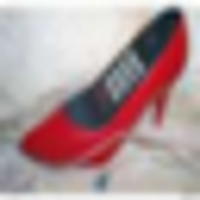

In [5]:
image_pool[max_index].resize((200,200))

In [96]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

def calculate_image_embeddings(image_pool, device='cuda'):
    """
    Calculate and save embeddings for a pool of images.
    
    Parameters:
    - image_pool: A list of PIL.Image objects.
    - device: Computation device, 'cuda' or 'cpu'.
    
    Returns:
    - A list of image embeddings.
    """
    # Load the model
    model, preprocess = clip.load('ViT-B/32', device=device)
    
    image_embeddings = []
    
    # Calculate the embeddings for each image
    with torch.no_grad():
        for image in image_pool:
            image_input = preprocess(image).unsqueeze(0).to(device)
            image_features = model.encode_image(image_input)
            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_embeddings.append(image_features)
    
    return image_embeddings

def find_most_similar_image(text_prompt, image_embeddings, image_pool, device='cuda'):
    """
    Calculate similarity between a text prompt and pre-calculated image embeddings,
    returning the index of the most similar image.
    
    Parameters:
    - text_prompt: A string representing the text prompt.
    - image_embeddings: A list of pre-calculated image embeddings.
    - device: Computation device, 'cuda' or 'cpu'.
    
    Returns:
    - Index of the most similar image and its similarity score.
    """
    # Load the model
    model, _ = clip.load('ViT-B/32', device=device)
    
    # Tokenize and encode the text prompt
    text_input = clip.tokenize(f'a photo of a {text_prompt}').to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        similarity_scores = torch.zeros(len(image_embeddings), device=device)
        
        # Calculate similarity for each image embedding
        for i, image_features in enumerate(image_embeddings):
            similarity = (image_features @ text_features.T).squeeze(0)
            similarity_scores[i] = similarity
        
        # Find the index of the highest similarity score
        max_index = similarity_scores.argmax()
        max_score = similarity_scores[max_index].item()
        
        # Display the most similar image with its index and similarity score
        plt.imshow(image_pool[max_index])
        plt.title(f'Index: {max_index}, Similarity Score: {max_score:.2f}')
        plt.axis('off')  # Hide axes for better visualization
        plt.show()
        
    return max_index, max_score, image_pool[max_index]

def find_and_display_similar_images(prompts, image_embeddings, image_pool, device='cuda'):
    """
    For each prompt in a list of prompts, find the most similar image from pre-calculated image embeddings
    and display the images in rows of 3, with each image's title showing the prompt, its index, and similarity score.
    
    Parameters:
    - prompts: A list of strings, each representing a text prompt.
    - image_embeddings: A list of pre-calculated image embeddings.
    - image_pool: A list of PIL.Image objects.
    - device: Computation device, 'cuda' or 'cpu'.
    """
    # Load the model
    model, preprocess = clip.load('ViT-B/32', device=device)
    
    num_prompts = len(prompts)
    plt.figure(figsize=(15, 5 * (num_prompts // 3 + (num_prompts % 3 > 0))))
    
    for idx, prompt in enumerate(prompts, start=1):
        # Tokenize and encode the text prompt
        text_input = clip.tokenize(f'a photo of a {prompt}').to(device)
        
        with torch.no_grad():
            text_features = model.encode_text(text_input)
            # Normalize features
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
            similarity_scores = torch.zeros(len(image_embeddings), device=device)
            
            # Calculate similarity for each image embedding
            for i, image_features in enumerate(image_embeddings):
                similarity = (image_features @ text_features.T).squeeze(0)
                similarity_scores[i] = similarity
            
            # Find the index of the highest similarity score
            max_index = similarity_scores.argmax()
            max_score = similarity_scores[max_index].item()
        
        # Plot the most similar image
        plt.subplot(num_prompts // 3 + (num_prompts % 3 > 0), 3, idx)
        plt.imshow(image_pool[max_index])
        plt.title(f'Prompt: {prompt}\nIndex: {max_index}, Score: {max_score:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Define the base paths
BASE_PATH = Path('/dsp/dsp_gpu_portal/sys/opfiles/Roni/bdd100k')
INPUT_PATH = BASE_PATH/'images'
TARGET_PATH = BASE_PATH/'labels'

In [9]:
image_pool = []
for subpath in os.listdir(INPUT_PATH):
    for img_path in os.listdir(INPUT_PATH/subpath):
        if len(image_pool)<3500:
            image_pool.append(Image.open((INPUT_PATH/subpath)/img_path))

In [10]:
len(image_pool)

3500

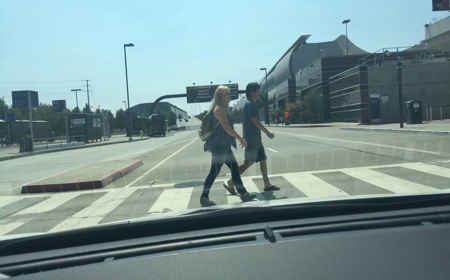

In [51]:
image_pool[0].resize((450, 280))

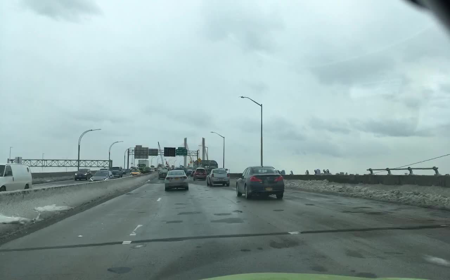

In [52]:
image_pool[1].resize((450, 280))

In [13]:
%%time
bdd100k_embeddings = calculate_image_embeddings(image_pool)

CPU times: user 4min 45s, sys: 5.39 s, total: 4min 50s
Wall time: 2min 23s


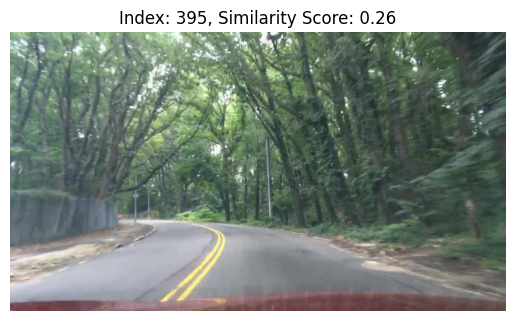

CPU times: user 3.2 s, sys: 688 ms, total: 3.89 s
Wall time: 3.47 s


In [82]:
%%time
prompt = 'Forest'
max_index, max_score, image = find_most_similar_image(prompt, bdd100k_embeddings, image_pool)

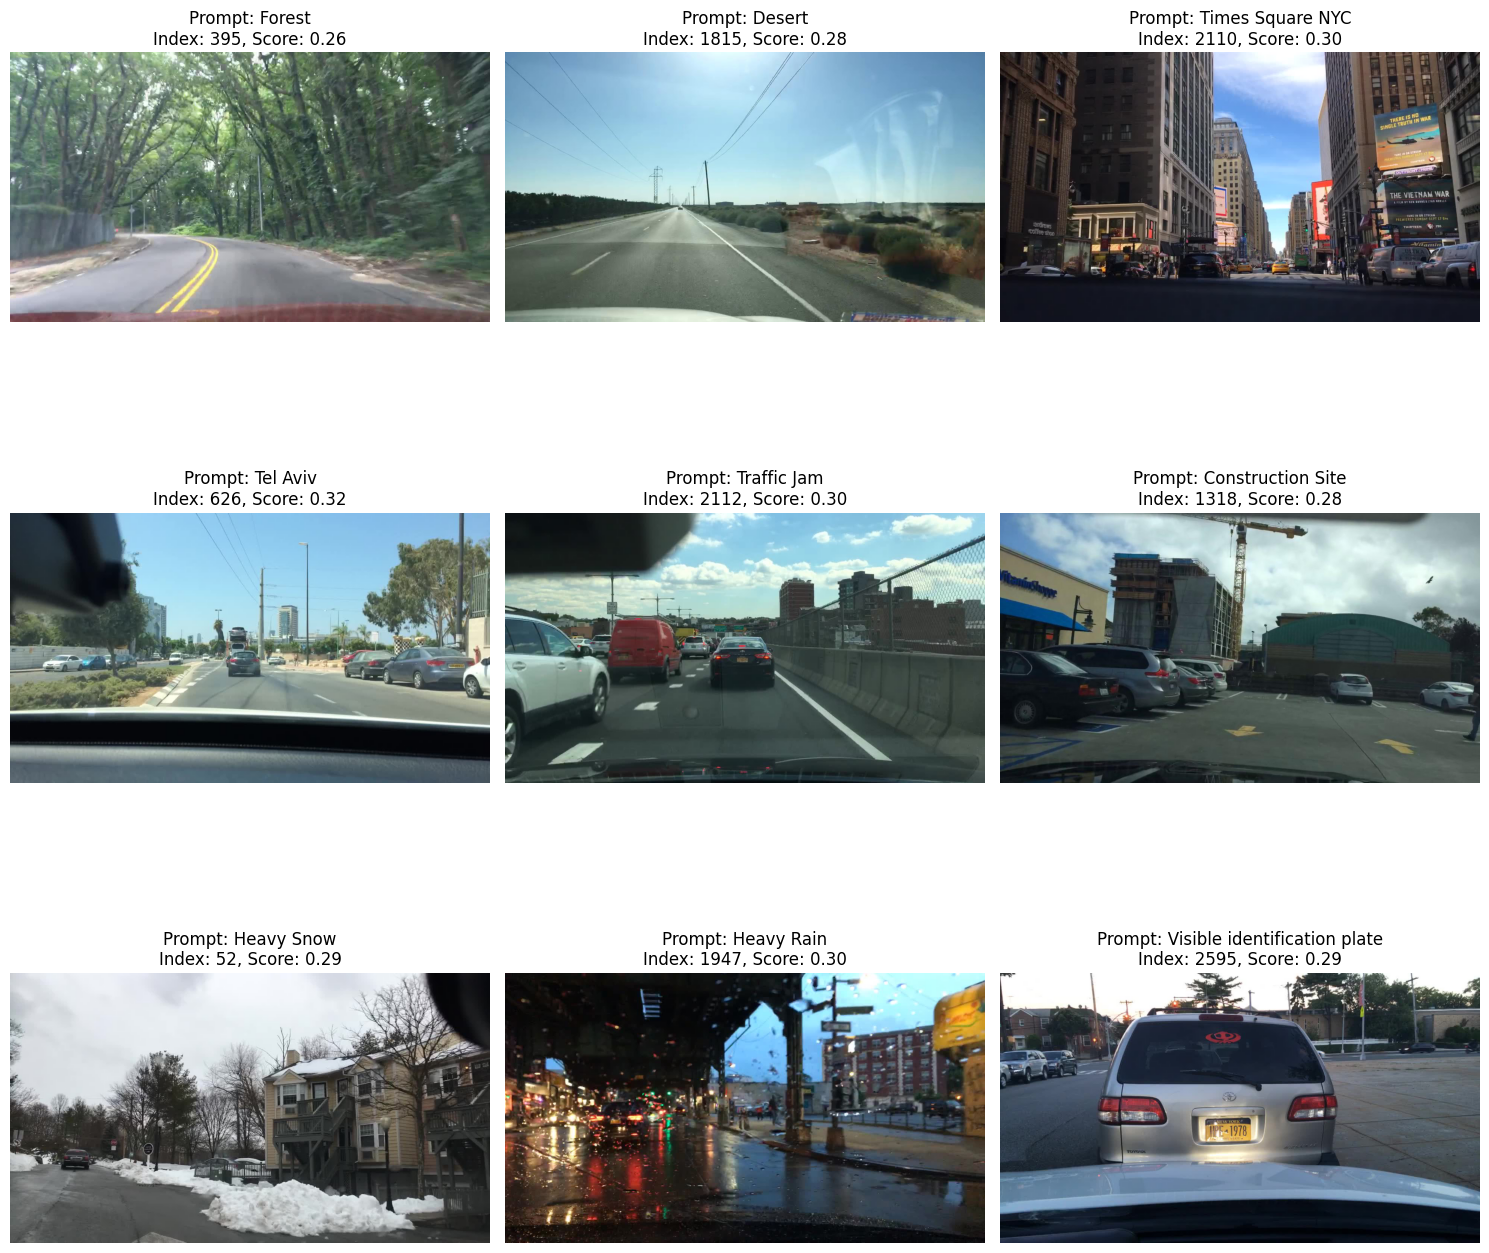

In [97]:
find_and_display_similar_images(
    prompts = ['Forest', 'Desert', 'Times Square NYC', 'Tel Aviv', 'Traffic Jam', 'Construction Site', 'Heavy Snow', 'Heavy Rain', 'Visible identification plate'],
    image_embeddings = bdd100k_embeddings,
    image_pool = image_pool
)